# *Salary prediction for Norwegian developers using different models*:

Dataset is implemented from [Kode24.no](https://www.kode24.no/files/2023/06/13/lonn2023.json)

Kode24 article: https://www.kode24.no/artikkel/her-er-lonnstallene-for-norske-utviklere-2024/81507953

***Features:***

- alder (age):
    - The age of the person (developer)  
    - had ranged values e.g (21-25) converted to midpoint --> 23
- utdanning: 
    - Number of high level education 
    - float (done)
- erfaring: 
    - Number of working experience (years) 
    - float (done)
- jobb: 
    - In house-Private, consultant, freelancer or in house public  
    - category --> numeric ( done)
- sted:
    - Where does the developer work geographically e.g (Oslo, Agder...etc.) 
    - category --> numeric (done)
- fag: 
    - Which field is the branch does the developer work in e.g ( backend, security...etc.)
    - category --> numeric (done) 
- bonus:
    - If the job offers bonus in addition to salary 
    - binary

***Output / Prediction:***

- lønn (salary):
    - Numeric
    - Given in NOK: Norwegian Krone

Dataset has also the number of college, but I choose to exclude it from the model

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Fetching data from URL as JSON and converting it to csv file
url = 'https://www.kode24.no/files/2023/06/13/lonn2023.json'
response = requests.get(url)
json_data = response.json()

# Parse JSON data
if isinstance(json_data, dict) and 'data' in json_data:
    json_data = json_data['data']

# Convert JSON data to DataFrame
df = pd.DataFrame(json_data)

# Save DataFrame to CSV
df.to_csv('lonn.csv', index=False)

In [3]:
df

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2,5,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000,Ja,Ja
1,26-30,0,1,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000,Nei,Nei
2,31-35,3,14,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000,Nei,Nei
3,26-30,,3,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000,Ja,Nei
4,31-35,4,0,"in-house, privat sektor",Viken,fullstack,under 10,350000,Nei,Nei
...,...,...,...,...,...,...,...,...,...,...
2336,21-25,0,0,"in-house, privat sektor",Viken,frontend,under 10,,Ja,Nei
2337,21-25,0,4,"in-house, privat sektor",Vestfold og Telemark,fullstack,under 10,,Nei,Nei
2338,26-30,5,5,"in-house, privat sektor",Trøndelag,frontend,under 10,,Nei,Nei
2339,36-40,0,20,konsulent,Oslo,frontend,under 10,,Nei,Nei


In [4]:
df.describe()

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
count,2341,2341,2341,2341,2341,2341,2341,2341,2341,2341
unique,11,12,45,4,12,16,7,376,2,2
top,26-30,3,2,"in-house, privat sektor",Oslo,fullstack,100 - 500,700000,Nei,Ja
freq,668,877,207,1187,1197,728,617,86,1603,1435


# Handling missing and duplicated data

In [5]:
# Custom function to check if a cell is empty or contains only whitespace
def is_empty_or_whitespace(cell):
    return isinstance(cell, str) and cell.strip() == ''

# Count cells with empty values
# apply runs given operation on all cells
empty_counts = df.map(is_empty_or_whitespace).sum()
empty_counts

alder         1
utdanning    76
erfaring      3
jobb          0
sted          0
fag           0
kolleger      0
lønn         35
bonus         0
fornøyd       0
dtype: int64

In [6]:
# Drop the rows that contain empty salary(lønn) value
# Reason for deleting instead of replacing is that the goal of my model
# is salary predicting, and there are only 35 rows of 2341
df = df.drop(df[df.lønn == ''].index)

In [7]:
# handling empty values in education and experience column
# Empty utdanning will be translated as "Not given" = 0
# Delete the 3 rows that contains empty experience value, 0 is ok, but empty no
pd.set_option('future.no_silent_downcasting', True) # To avoid problems with future pandas versions

df['utdanning'] = df['utdanning'].replace('', 0)
df = df.drop(df[df.erfaring == ''].index)

In [8]:
# Check if rows have been deleted
empty_counts = df.map(is_empty_or_whitespace).sum()
empty_counts

alder        0
utdanning    0
erfaring     0
jobb         0
sted         0
fag          0
kolleger     0
lønn         0
bonus        0
fornøyd      0
dtype: int64

In [9]:
int(df.duplicated().sum())

3

In [10]:
df = df.drop_duplicates()
int(df.duplicated().sum())

0

In [11]:
# Finally, in this part I want to remove 'kolleger' column because 
# It 'm not interested in it
df.drop('kolleger', axis=1, inplace=True)

# Handling datatypes | Feature engineering

In [12]:
df.dtypes

alder        object
utdanning    object
erfaring     object
jobb         object
sted         object
fag          object
lønn         object
bonus        object
fornøyd      object
dtype: object

In [13]:
df.describe()

,alder,utdanning,erfaring,jobb,sted,fag,lønn,bonus,fornøyd
count,2300,2300,2300,2300,2300,2300,2300,2300,2300
unique,10,11,44,4,12,16,375,2,2
top,26-30,3,2,"in-house, privat sektor",Oslo,fullstack,750000,Nei,Ja
freq,660,870,204,1163,1176,718,86,1572,1417


In [14]:
# This function converts ranged values such as 'alder' to midPoint
def convert_to_midpoint(value):
    low, high = map(int, value.split('-'))
    return (low + high) / 2

In [15]:
print("Alder unique values before mapping: " + str(df['alder'].unique()))
df['alder'] = df['alder'].apply(convert_to_midpoint)
print("Alder unique values after mapping: " + str(df['alder'].unique()))

Alder unique values before mapping: ['21-25' '26-30' '31-35' '36-40' '15-20' '46-50' '41-45' '56-60' '51-55'
 '61-65']
Alder unique values after mapping: [23.  28.  33.  38.  17.5 48.  43.  58.  53.  63. ]


In [16]:
df.dtypes

alder        float64
utdanning     object
erfaring      object
jobb          object
sted          object
fag           object
lønn          object
bonus         object
fornøyd       object
dtype: object

In [17]:
# Handling data type
df['utdanning']  = df['utdanning'].astype('float64')
df['erfaring']  = df['erfaring'].astype('float64')

In [18]:
df['jobb'].unique()

array(['in-house, privat sektor', 'frilans / selvstendig næringsdrivende',
       'konsulent', 'in-house, offentlig/kommunal sektor'], dtype=object)

In [19]:
# Converting job into numeric to use it in the model
IN_HOUSE_PRIVATE = 1
FREELANCER = 2
CONSULTANT = 3
IN_HOUSE_PUBLIC = 4

job_mapping = {
    'in-house, privat sektor': IN_HOUSE_PRIVATE,
    'frilans / selvstendig næringsdrivende': FREELANCER,
    'konsulent': CONSULTANT,
    'in-house, offentlig/kommunal sektor': IN_HOUSE_PUBLIC
}

df['job_numeric'] = df['jobb'].map(job_mapping)

df['job_numeric'].unique()

array([1, 2, 3, 4], dtype=int64)

In [20]:
# Do same for fag even if there are quiet many unique values (16)
df['fag'].unique()

array(['sikkerhet', 'fullstack', 'ingen av disse', 'frontend',
       'programvare', 'backend', 'UX / design', 'app',
       'ledelse/administrativt', 'devops', 'automatisering', 'databaser',
       'data science', 'testing', 'arkitektur', 'embedded/IOT/maskinvare'],
      dtype=object)

In [21]:
SECURITY = 1
FULLSTACK = 2
NONE_OF_THEM = 3
FRONTEND = 4
SOFTWARE = 5
BACKEND = 6
UX_DESIGN = 7
APP = 8
LEADERSHIP_ADMINISTRATIVE = 9
DEVOPS = 10
AUTOMATION = 11
DATABASES = 12
DATA_SCIENCE = 13
TESTING = 14
ARCHITECTURE = 15
EMBEDDED_IOT_HARDWARE = 16

In [22]:
fag_mapping = {
    'sikkerhet': SECURITY,
    'fullstack': FULLSTACK,
    'ingen av disse': NONE_OF_THEM,
    'frontend': FRONTEND,
    'programvare': SOFTWARE,
    'backend': BACKEND,
    'UX / design': UX_DESIGN,
    'app': APP,
    'ledelse/administrativt': LEADERSHIP_ADMINISTRATIVE,
    'devops': DEVOPS,
    'automatisering': AUTOMATION,
    'databaser': DATABASES,
    'data science': DATA_SCIENCE,
    'testing': TESTING,
    'arkitektur': ARCHITECTURE,
    'embedded/IOT/maskinvare': EMBEDDED_IOT_HARDWARE
}

# Example usage in mapping
df['fag_numeric'] = df['fag'].map(fag_mapping)

df['fag_numeric'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [23]:
df['sted'].unique()

array(['Oslo', 'Innlandet', 'Viken', 'Vestland', 'Troms og Finnmark',
       'Trøndelag', 'Rogaland', 'Vestfold og Telemark', 'Agder',
       'Møre og Romsdal', 'Nordland', 'utlandet'], dtype=object)

In [24]:
OSLO = 1
INNLANDET = 2
VIKEN = 3
VESTLAND = 4
TROMS_OG_FINNMARK = 5
TRONDELAG = 6
ROGALAND = 7
VESTFOLD_OG_TELEMARK = 8
AGDER = 9
MORE_OG_ROMSDAL = 10
NORDLAND = 11
ABROAD = 12


In [25]:
sted_mapping = {
    'Oslo': OSLO,
    'Innlandet': INNLANDET,
    'Viken': VIKEN,
    'Vestland': VESTLAND,
    'Troms og Finnmark': TROMS_OG_FINNMARK,
    'Trøndelag': TRONDELAG,
    'Rogaland': ROGALAND,
    'Vestfold og Telemark': VESTFOLD_OG_TELEMARK,
    'Agder': AGDER,
    'Møre og Romsdal': MORE_OG_ROMSDAL,
    'Nordland': NORDLAND,
    'utlandet': ABROAD
}

# Example usage in mapping
df['sted_numeric'] = df['sted'].map(sted_mapping)

df['sted_numeric'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [26]:
# Mapping columns with binary values to 1,0
# Could use bool, but I prefer this for readability

YES, NO = 1, 0
mapping = {'Ja': YES, 'Nei': NO}

# Convert bonus and 'fornøyd' to binary datatype
df['bonus'] = df['bonus'].map(mapping)
df['fornøyd'] = df['fornøyd'].map(mapping)

In [27]:
# Finally, converting salary to float.
df['lønn'] = df['lønn'].astype('float64')

In [28]:
df.dtypes

alder           float64
utdanning       float64
erfaring        float64
jobb             object
sted             object
fag              object
lønn            float64
bonus             int64
fornøyd           int64
job_numeric       int64
fag_numeric       int64
sted_numeric      int64
dtype: object

In [29]:
df.shape

(2300, 12)

In [30]:
df.columns

Index(['alder', 'utdanning', 'erfaring', 'jobb', 'sted', 'fag', 'lønn',
       'bonus', 'fornøyd', 'job_numeric', 'fag_numeric', 'sted_numeric'],
      dtype='object')

# Analyze and understand data

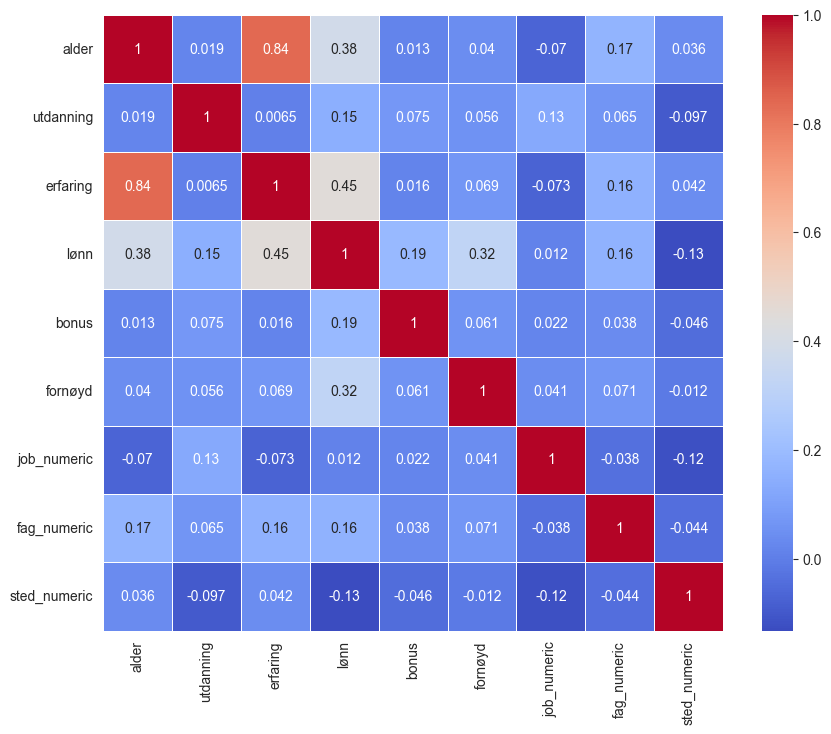

In [31]:
correlation_matrix = df[['alder', 'utdanning', 'erfaring', 'lønn',
       'bonus', 'fornøyd', 'job_numeric', 'fag_numeric', 'sted_numeric']].corr()  # Calculate the correlation matrix

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Show the heatmap
plt.show()

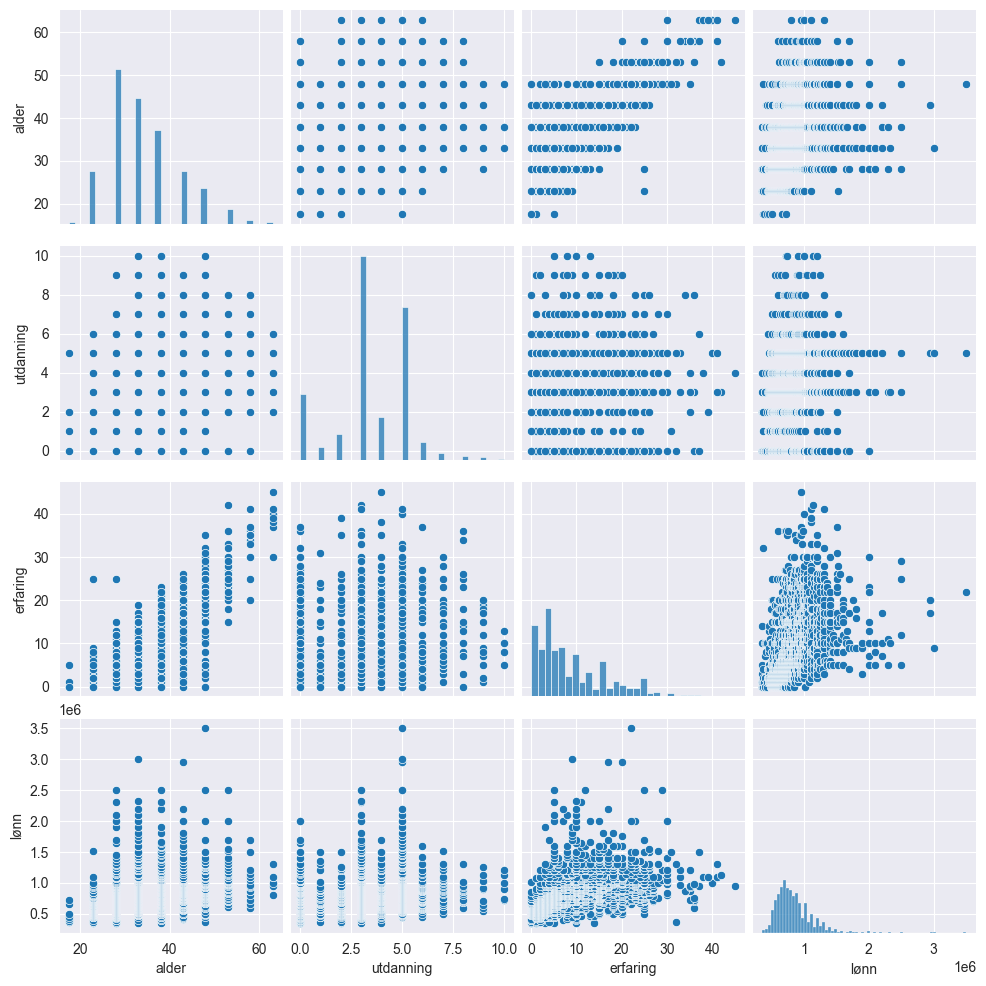

In [32]:
# Understand impact/correlation of experience, education and age on salary
sns.pairplot(df[['alder', 'utdanning', 'erfaring', 'lønn']])
plt.show()

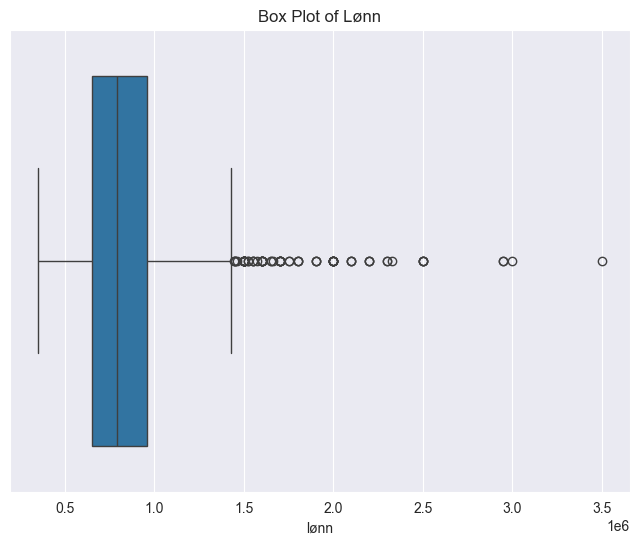

In [33]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['lønn'])
plt.title('Box Plot of Lønn')
plt.show()

In [34]:
int(df['lønn'].max())

3500000

In [35]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['lønn'].quantile(0.25)
Q3 = df['lønn'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['lønn'] < (Q1 - 1.5 * IQR)) | (df['lønn'] > (Q3 + 1.5 * IQR))]
outliers.shape

(79, 12)

In [36]:
# Outliers have 79 row that can mislead my model.
# Therefore, I choose to remove them from dataset
print("Before removing outlier: ", df.shape)
outlier_filter = (df['lønn'] < (Q1 - 1.5 * IQR)) | (df['lønn'] > (Q3 + 1.5 * IQR))
df = df[~outlier_filter].reset_index(drop=True)
print("After removing outlier: ", df.shape)

Before removing outlier:  (2300, 12)
After removing outlier:  (2221, 12)


In [37]:
# Select only numerical columns
numerical_outliers = outliers.select_dtypes(include=['number'])

# Group by 'fag' and calculate mean of numerical columns
grouped_summary = numerical_outliers.groupby(outliers['fag']).max()
grouped_summary

,alder,utdanning,erfaring,lønn,bonus,fornøyd,job_numeric,fag_numeric,sted_numeric
fag,,,,,,,,,
app,33.0,5.0,10.0,2000000.0,0,1,3,8,1
arkitektur,48.0,5.0,25.0,2500000.0,1,1,3,15,8
automatisering,33.0,6.0,8.0,1600000.0,1,1,3,11,1
backend,53.0,5.0,26.0,2950000.0,1,1,3,6,6
data science,33.0,5.0,10.0,1900000.0,1,1,3,13,1
devops,43.0,5.0,22.0,2000000.0,1,1,3,10,7
embedded/IOT/maskinvare,43.0,5.0,17.0,2950000.0,1,1,1,16,6
frontend,43.0,5.0,19.0,2330000.0,1,1,3,4,1
fullstack,53.0,5.0,29.0,3000000.0,1,1,3,2,12


# Linear Regression model for predicting salary

***Main concepts***
The equation can be written as:

* **Simple linear regression**: *y = ɑX + b + e*
* **Multi linear regression**: *y = ɑ1X1 + a2X2 + a3X3 + anXn + b + e*

Where:

* y: is the independent variable
* x: is the dependent variable (target)
* a: is the slope of the linear line ( imact the line diagonaly)
* b: is the intercept
* e: is the error (difference between predicted value and the actual value)



In [38]:
# Shuffle the data before splitting it to avoid bias or any ordered data
# Shuffling is set to True by default in train_test_split function, but
# I use sample because dataset is small, have control and practise
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [39]:
# Defining features and label
features = df_shuffled[['alder', 'utdanning', 'erfaring', 'job_numeric', 'sted_numeric', 'fag_numeric', 'bonus']]
label = df_shuffled['lønn']

In [40]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1776, 7), (445, 7), (1776,), (445,))

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [43]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [44]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 29506602246.41902


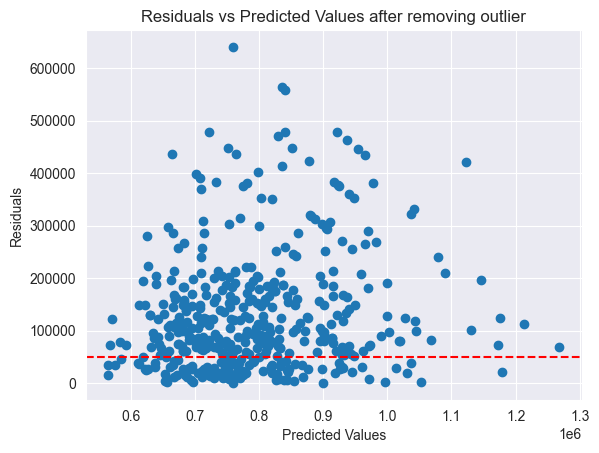

In [45]:
actual_minus_predicted = (y_test - y_pred).abs() #  abs() to include values with minus sign in the filter
plt.scatter(y_pred, actual_minus_predicted)
plt.axhline(50000, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values after removing outlier')
plt.show()

In [46]:
# Check number and the difference between actual and predicted values
# with error range 50 000 NOK
err_pred_under_50k = actual_minus_predicted[actual_minus_predicted < 50000]
print("Number of prediction with err smaller than 50.000 NOK = ", len(err_pred_under_50k))
print("N X_test == "+str(len(X_test))+ " This means correct prediction (under 50k) is " + str(len(err_pred_under_50k)/len(X_test)))
err_pred_under_50k

Number of prediction with err smaller than 50.000 NOK =  116
N X_test == 445 This means correct prediction (under 50k) is 0.2606741573033708


1872    35494.160780
937     14788.741474
196     13730.909402
1780    40558.388505
111     26993.366340
            ...     
668      2217.513862
1233      437.661023
1868     9665.916526
1193    20186.388795
543     35222.724059
Name: lønn, Length: 116, dtype: float64

In [47]:
manual_features = pd.DataFrame({
    'alder': [30],
    'utdanning': [3],
    'erfaring': [3],
    'job_numeric': [IN_HOUSE_PRIVATE],
    'sted_numeric': [VESTFOLD_OG_TELEMARK],
    'fag_numeric': [FULLSTACK],
    'bonus': [1]
})

salary_prediction = model.predict(manual_features)
print("Your salary prediction is = ", int(salary_prediction[0]))

Your salary prediction is =  714530


# Decision tree

We saw in analyzing section that features has not necessarily linear correlation

Especially when data has both continuous and categorical features

**decision tree highlights**
- It is simply a bunch of if-else connected to each other in a tree model
- Tree means we have nodes (one root node), edges and leaf
    - Root node is the feature and it's evaluation (condition)
    -  Ex: my tree might look like following:
    -                           [experience <= 10]                      Depth 1 (Root node)
                                /              \                            (edge) leads to next outcome
                       [age <= 30]           [bonus_included == 1]      Depth 2
                         /     \                 /          \
                 [salary=550K] [salary=600K] [salary=750K] [salary=1M]  Depth 3  (leaf nodes)

In [48]:
decision_tree_regressor = DecisionTreeRegressor(random_state=42)

In [49]:
# Finding the most optimized max_depth to avoid over/under fitting
max_depth_params = {'max_depth':[3, 4, 5, 6, 7, 8, 9, 10]}

grid_search = GridSearchCV(estimator=decision_tree_regressor, param_grid=max_depth_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best max_depth
print(f"Optimal max_depth: {grid_search.best_params_['max_depth']}")
print(f"Best MSE: {-grid_search.best_score_}")

Optimal max_depth: 5
Best MSE: 29159630660.08012


In [50]:
decision_tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=grid_search.best_params_['max_depth'])
decision_tree_regressor.fit(X_train, y_train)

decision_tree_regressor.score(X_train, y_train)

y_pred_det = decision_tree_regressor.predict(X_test)
mse = mean_squared_error(y_test, decision_tree_regressor.predict(X_test))
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 28904842943.38078


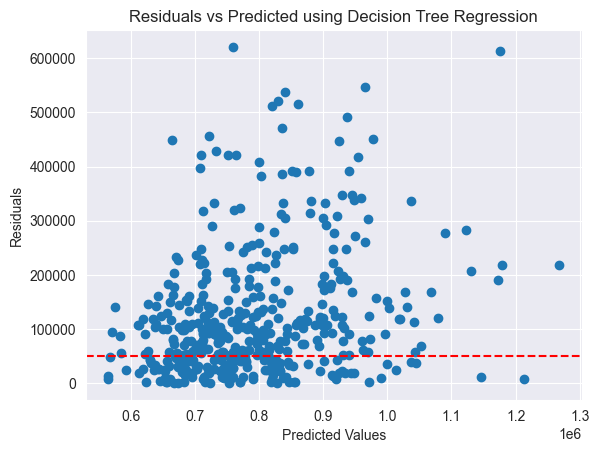

In [51]:
actual_minus_predicted_det = (y_test - y_pred_det).abs()
plt.scatter(y_pred, actual_minus_predicted_det)
plt.axhline(50000, color='red', linestyle='--') # To see prediction with difference smaller than 50 000 NOK
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted using Decision Tree Regression')
plt.show()

In [52]:
err_pred_under_50k_det = actual_minus_predicted_det[actual_minus_predicted_det < 50000]
print("Number of prediction with err smaller than 50.000 NOK = ", len(err_pred_under_50k_det))
print("N X_test == "+str(len(X_test))+ " This means correct prediction (under 50k) is " + str(len(err_pred_under_50k_det)/len(X_test)))
err_pred_under_50k_det

Number of prediction with err smaller than 50.000 NOK =  133
N X_test == 445 This means correct prediction (under 50k) is 0.298876404494382


1940    16622.023810
1872    13377.976190
700     40535.616438
100     43377.976190
1641    25535.616438
            ...     
620     24248.750000
1868      976.972222
205      3225.481481
1996     9464.383562
2192    22026.593023
Name: lønn, Length: 133, dtype: float64

In [53]:
salary_prediction_det = decision_tree_regressor.predict(manual_features)
print("Your salary prediction is = ", int(salary_prediction_det[0]))

Your salary prediction is =  778600


# Random Forest Regressor

In [54]:
rnd_forest_regressor = RandomForestRegressor(random_state=42)

# Finding the most optimized max_depth to avoid over/under fitting
max_depth_params = {'max_depth':[3, 4, 5, 6, 7, 8, 9, 10]}

grid_search = GridSearchCV(estimator=rnd_forest_regressor, param_grid=max_depth_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best max_depth
print(f"Optimal max_depth: {grid_search.best_params_['max_depth']}")
print(f"Best MSE: {-grid_search.best_score_}")

Optimal max_depth: 6
Best MSE: 25219494860.7647


In [55]:
rnd_forest_regressor = RandomForestRegressor(random_state=42, max_depth=grid_search.best_params_['max_depth'])
rnd_forest_regressor.fit(X_train, y_train)

y_pred_rnd = rnd_forest_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rnd)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 24119896606.83589


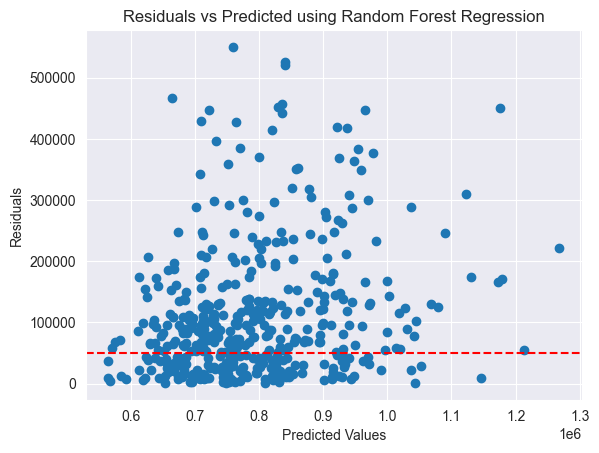

In [56]:
actual_minus_predicted_rnd = (y_test - y_pred_rnd).abs()
plt.scatter(y_pred, actual_minus_predicted_rnd)
plt.axhline(50000, color='red', linestyle='--') # To see prediction with difference smaller than 50 000 NOK
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted using Random Forest Regression')
plt.show()

In [57]:
err_pred_under_50k_rnd = actual_minus_predicted_rnd[actual_minus_predicted_rnd < 50000]
print("Number of prediction with err smaller than 50.000 NOK = ", len(err_pred_under_50k_rnd))
print("N X_test == "+str(len(X_test))+ " This means correct prediction (under 50k) is " + str(len(err_pred_under_50k_rnd)/len(X_test)))
err_pred_under_50k_rnd

Number of prediction with err smaller than 50.000 NOK =  152
N X_test == 445 This means correct prediction (under 50k) is 0.3415730337078652


1940    30340.327411
1872     9506.448487
700     46884.270497
937     43797.344120
1641    23007.484221
            ...     
1610     7639.073891
1193    12355.434880
205     37141.952157
680     36534.704988
1996     8844.547509
Name: lønn, Length: 152, dtype: float64

In [58]:
salary_prediction_rnd = rnd_forest_regressor.predict(manual_features)
print("Your salary prediction is = ", int(salary_prediction_rnd[0]))

Your salary prediction is =  707466


# Gradient Boosting Regressor

In [59]:
# To ensure equality between vanilla decision tree and GDB
# I will try to find the most optimised n_estimators (number of trees used in the model)
gdb_model = GradientBoostingRegressor(random_state=42, n_estimators=1000)

gdb_model.fit(X_train, y_train)

# Monitor performance
best_n_estimators = 0
best_score = float('inf')
batch = 50  # Number of iterations to wait for improvement
no_improvement = 0

for stage, y_pred_gdb in enumerate(gdb_model.staged_predict(X_test)):
    score = mean_squared_error(y_test, y_pred_gdb)
    if score < best_score:
        best_score = score
        best_n_estimators = stage + 1
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= batch: # Passed 50 without improvement
            break

print("Best N estimators == ", best_n_estimators)
print("It's best score   == ", best_score)
# Reinit model with best n_estimators
gdb_model = GradientBoostingRegressor(random_state=42, n_estimators=best_n_estimators)

gdb_model.fit(X_train, y_train)

Best N estimators ==  118
It's best score   ==  21450882018.36287


GradientBoostingRegressor(n_estimators=118, random_state=42)

In [60]:
y_pred_gdb = gdb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gdb)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 21450882018.36287


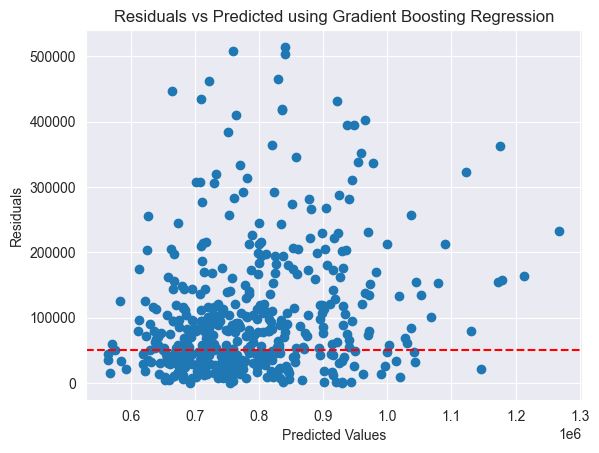

In [61]:
actual_minus_predicted_gdb = (y_test - y_pred_gdb).abs()
plt.scatter(y_pred, actual_minus_predicted_gdb)
plt.axhline(50000, color='red', linestyle='--') # To see prediction with difference smaller than 50 000 NOK
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted using Gradient Boosting Regression')
plt.show()

In [62]:
err_pred_under_50k_gdb = actual_minus_predicted_gdb[actual_minus_predicted_gdb < 50000]
print("Number of prediction with err smaller than 50.000 NOK = ", len(err_pred_under_50k_gdb))
print("N X_test == "+str(len(X_test))+ " This means correct prediction (under 50k) is " + str(len(err_pred_under_50k_gdb)/len(X_test)))
err_pred_under_50k_gdb

Number of prediction with err smaller than 50.000 NOK =  155
N X_test == 445 This means correct prediction (under 50k) is 0.34831460674157305


1872    35473.943903
937     13208.157916
1641    17873.203798
196     29156.293049
942      1621.601914
            ...     
494     46225.139861
205     31180.238113
680     14149.652412
1996    44900.441194
2192    46660.968255
Name: lønn, Length: 155, dtype: float64

In [63]:
salary_prediction_gdb = gdb_model.predict(manual_features)
print("Your salary prediction is = ", int(salary_prediction_gdb[0]))

Your salary prediction is =  694101
